## Topic discovery: yelp review

In [1]:
# from huggingface_hub import hf_hub_download 
import torch
from datasets import load_dataset, load_from_disk
import evaluate
import transformers
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
from transformers import MistralForCausalLM
from transformers import TrainingArguments, Trainer
from peft import LoraConfig, TaskType, get_peft_model
from peft import PeftConfig, PeftModel
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from huggingface_hub import notebook_login
from accelerate import init_empty_weights, load_checkpoint_and_dispatch, infer_auto_device_map, dispatch_model

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import re
import os
import glob

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string

D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
print(transformers.__version__)

4.35.2


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.3.0+cu118
True


In [4]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [5]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

def load_tokenizer_llm(AutoModelForClass, model_name, model_path, cache_dir, to_device=True, **kwargs):
    """
    if use load_in_4bit=True, do not set to_device=True
    kwargs:
        - device_map
        - torch_dtype
        - load_in_4bit
    """
    if not os.path.isfile(model_path + '/tokenizer.json'):
        print('no existing tokenizer found. Download from HF')
        tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                                  cache_dir=cache_dir,
                                                  **kwargs
                                                 ) # to load tokenizer to cache
    else:
        print('existing tokenizer found. Load from local')
        tokenizer = AutoTokenizer.from_pretrained(model_path, 
                                                  cache_dir=cache_dir, 
                                                  local_flies_only=True)
    if not bool(glob.glob(model_path + '/model*.safetensors')):
        print('no existing model found. Download from HF')
        model = AutoModelForClass.from_pretrained(model_name,
                                                     cache_dir=cache_dir,
                                                     **kwargs
                                                    )
    else:
        print('existing model found. Load from local')
        model = AutoModelForClass.from_pretrained(model_path, 
                                                 cache_dir=cache_dir,
                                                 local_files_only=True)
    
    if to_device:
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        #device.reset()
        model.to(device) # use GPU. Do not need this if using load_in_4bit as it's already been set to the correct devices
        
    return tokenizer, model

In [6]:
llm_repo_dir = 'D:/projects/LLM'
cache_dir = '/cygdrive/d/projects/LLM/.cache'
os.environ['TRANSFORMERS_CACHE'] = cache_dir
os.environ['HF_HOME'] = cache_dir + '/huggingface'
os.environ['XDG_CACHE_HOME'] = cache_dir
os.environ['HF_DATASETS_CACHE'] = cache_dir

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [92]:
model_name = 'google-bert/bert-base-cased'
model_path = cache_dir + '/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e'

AutoModelForClass = AutoModelForSequenceClassification
to_device = True
tokenizer, model = load_tokenizer_llm(AutoModelForClass, model_name, model_path, cache_dir, to_device=to_device)

existing tokenizer found. Load from local
existing model found. Load from local


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /cygdrive/d/projects/LLM/.cache/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
dataset_path = cache_dir + '/parquet/yelp_polarity' # cache_dir + '/parquet/yelp_review_full-e22176106d6e7534'
dataset_name = 'yelp_polarity' # yelp_review_full

if not os.path.isdir(dataset_path):
    dataset = load_dataset(dataset_name, cache_dir=cache_dir + '/parquet')
else:
    dataset = load_dataset(dataset_path)

In [8]:
tokenized_data_path = cache_dir + '/tokenized_dataset_yelp_polarity_bert'

tokenized_datasets = load_from_disk(tokenized_data_path)
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [10]:
print(type(small_train_dataset))
print(small_train_dataset.shape)

<class 'datasets.arrow_dataset.Dataset'>
(1000, 5)


In [11]:
token_length = [len([x for x in y if x != 0]) for y in small_train_dataset['input_ids']]

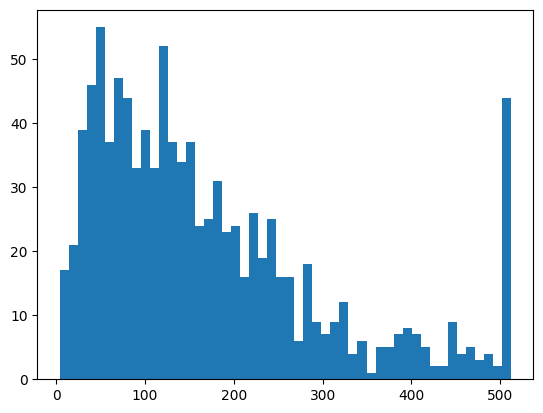

In [12]:
plt.hist(token_length, bins=50)
plt.show()

### use pre-trained BERT cls token as comment embedding

In [30]:
input_ids = torch.tensor(small_train_dataset['input_ids'], device=device)

In [139]:
%%time

#cls_embedding = torch.tensor([]).to('cuda')
cls_embedding = []

with torch.no_grad():
    for i in range(input_ids.shape[0]):
        output = model(input_ids[i].reshape(1,-1),
                      output_hidden_states=True)
        #cls_embedding = torch.cat((cls_embedding, output.hidden_states[-1][0,0,:]), dim=-1)
        cls_embedding.append(output.hidden_states[-1][0,0,:].cpu().numpy())
cls_embedding = np.array(cls_embedding)

CPU times: total: 12.8 s
Wall time: 38.7 s


D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


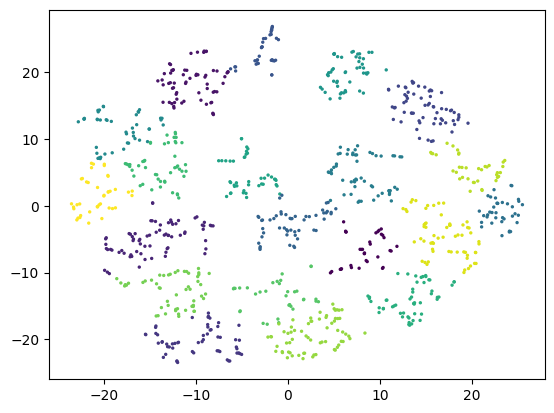

In [140]:
pipe = Pipeline([('scaler',StandardScaler()),
                 ('pca',PCA(n_components=20)),
                 ('tsne',TSNE(perplexity=10, learning_rate=1, random_state=123))
                ])
cls_embedding_tsne = pipe.fit_transform(cls_embedding)
km = KMeans(n_clusters=20)
km.fit(cls_embedding_tsne)

plt.scatter(cls_embedding_tsne[:,0],
            cls_embedding_tsne[:,1], 
            s=2,
            c=km.labels_)

In [141]:
nonzero_token_length = (np.array(small_train_dataset['input_ids'])!=0).sum(axis=1)

df_comment_from_label = pd.DataFrame({'comment':small_train_dataset['text'],
                                      'x':cls_embedding_tsne[:,0],
                                      'y':cls_embedding_tsne[:,1],
                                      'label':km.labels_,
                                      'nonzero_token_length':nonzero_token_length,
                                      'sentiment':small_train_dataset['label']})

In [142]:
df_comment_from_label.groupby('label')[['nonzero_token_length', 'sentiment']].mean().sort_values('sentiment')

,nonzero_token_length,sentiment
label,,
14,138.470588,0.323529
18,229.491803,0.327869
7,265.736842,0.342105
10,508.346939,0.346939
17,316.054054,0.351351
12,183.943396,0.358491
4,416.500000,0.406250
3,121.561404,0.421053
2,81.097222,0.486111


### Look at cluster center

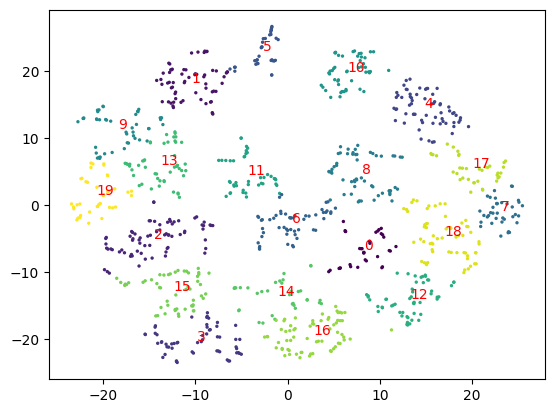

In [143]:
cluster_centers = df_comment_from_label.groupby('label')[['x','y']].mean()
plt.scatter(comment_embedding_tsne[:,0],
            comment_embedding_tsne[:,1], 
            s=2,
            c=km.labels_)
for cluster in range(cluster_centers.shape[0]):
    plt.annotate(cluster, 
                 (cluster_centers.iloc[cluster]['x'], cluster_centers.iloc[cluster]['y']), 
                c='r')

In [144]:
df_comment_from_label.groupby('label')['nonzero_token_length'].describe()[['count','mean','std']].sort_values('mean')

,count,mean,std
label,,,
5,34.0,14.941176,5.882389
1,63.0,31.777778,5.865274
9,45.0,45.355556,6.650890
13,48.0,54.583333,7.964905
19,40.0,62.000000,8.755950
11,42.0,79.452381,19.287557
2,72.0,81.097222,7.406050
15,53.0,102.792453,8.113044
3,57.0,121.561404,7.676536


In [145]:
df_comment_from_label.groupby('label')['sentiment'].describe()[['count','mean','std']].sort_values('mean')

,count,mean,std
label,,,
14,34.0,0.323529,0.474858
18,61.0,0.327869,0.473333
7,38.0,0.342105,0.480783
10,49.0,0.346939,0.480929
17,37.0,0.351351,0.483978
12,53.0,0.358491,0.484146
4,64.0,0.406250,0.495015
3,57.0,0.421053,0.498117
2,72.0,0.486111,0.503315


### use fine-tuned BERT for word embedding

In [17]:
input_ids = torch.tensor(small_train_dataset['input_ids'], device=device)

In [34]:
ft_model_dir = cache_dir + '/ft_lora_yelp_polarity'
model_path = cache_dir + '/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e'
num_labels = 2
model_pretrained = AutoModelForSequenceClassification.from_pretrained(model_path, 
                                                           num_labels=num_labels, 
                                                           cache_dir=cache_dir, 
                                                           local_files_only=True)
model_lora = PeftModel.from_pretrained(model_pretrained, ft_model_dir)
model_lora.to(device)
model_lora.eval()

D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /cygdrive/d/projects/LLM/.cache/models--google-bert--bert-base-cased/snapshots/cd5ef92a9fb2f889e972770a36d4ed042daf221e and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(28996, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(
                    in_features=768, out_features=768, bias=True
                    (lora_dropout): Dropout(p=0.1, inplace=False)
                    (lora_A): Linear(in_features=768, out_features=50, bias=False)
                    (lora_B): Linear(in_features=50, out_features=768, bias=False)
    

In [19]:
%%time

#cls_embedding = torch.tensor([]).to('cuda')
cls_embedding_lora = []

with torch.no_grad():
    for i in range(input_ids.shape[0]):
        output = model_lora(input_ids[i].reshape(1,-1),
                      output_hidden_states=True)
        cls_embedding_lora.append(output.hidden_states[-1][0,0,:].cpu().numpy())
cls_embedding_lora = np.array(cls_embedding_lora)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


CPU times: total: 29.6 s
Wall time: 1min 2s


D:\cygdrive\d\projects\LLM_py38\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


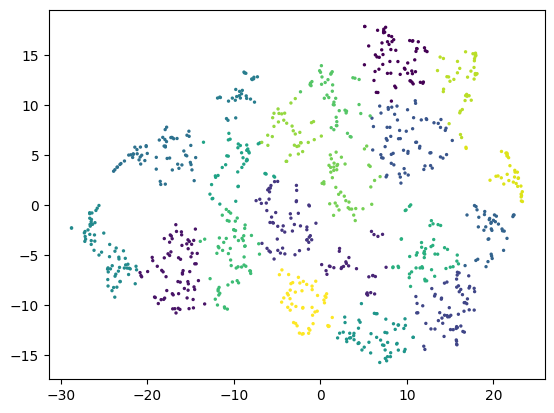

In [20]:
pipe = Pipeline([('scaler',StandardScaler()),
                 ('pca',PCA(n_components=20)),
                 ('tsne',TSNE(perplexity=20, learning_rate=1, random_state=123))
                ])
cls_embedding_lora_tsne = pipe.fit_transform(cls_embedding_lora)
km_lora = KMeans(n_clusters=20)
km_lora.fit(cls_embedding_lora_tsne)

plt.scatter(cls_embedding_lora_tsne[:,0],
            cls_embedding_lora_tsne[:,1], 
            s=2,
            c=km_lora.labels_)

In [21]:
nonzero_token_length = (np.array(small_train_dataset['input_ids'])!=0).sum(axis=1)

df_comment_from_label = pd.DataFrame({'comment':small_train_dataset['text'],
                                      'x':cls_embedding_lora_tsne[:,0],
                                      'y':cls_embedding_lora_tsne[:,1],
                                      'label':km_lora.labels_,
                                      'nonzero_token_length':nonzero_token_length,
                                      'sentiment':small_train_dataset['label']})

In [22]:
df_comment_from_label.groupby('label')[['nonzero_token_length', 'sentiment']].mean().sort_values('sentiment')

,nonzero_token_length,sentiment
label,,
10,161.982456,0.017544
4,249.548387,0.048387
6,392.615385,0.051282
19,121.300000,0.060000
18,504.030303,0.060606
2,143.000000,0.100000
12,266.764706,0.137255
13,74.550000,0.250000
3,103.660714,0.357143


In [23]:
df_comment_from_label.groupby('label')['sentiment'].describe()[['count','mean','std']].sort_values('mean')

,count,mean,std
label,,,
10,57.0,0.017544,0.132453
4,62.0,0.048387,0.216335
6,39.0,0.051282,0.223456
19,50.0,0.060000,0.239898
18,33.0,0.060606,0.242306
2,30.0,0.100000,0.305129
12,51.0,0.137255,0.347540
13,60.0,0.250000,0.436667
3,56.0,0.357143,0.483494


## LDA

In [ ]:
# lowercase
# remove punctuations
# tokenization
# remove stopwords
# lemmatization
# tfidf
# LDA

## LDA on cluster of words from BERT

In [46]:
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jacky\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [86]:
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

def preprocess_pipeline(x):
    x = x.lower()
    x = remove_punctuation(x)
    x = word_tokenize(x)
    x = [s for s in x if s not in stopwords.words('english')]
    return x
    
class Lemmatizer:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def fit(self, X, y):
        return self
    
    def nltk_pos_tagger(self, nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None
        
    def lemmatize_sentence(self, sentence):
        nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
        wordnet_tagged = map(lambda x: (x[0], self.nltk_pos_tagger(x[1])), nltk_tagged)
        lemmatized_sentence = []
        
        for word, tag in wordnet_tagged:
            if tag is None:
                lemmatized_sentence.append(word)
            else:
                lemmatized_sentence.append(self.lemmatizer.lemmatize(word, tag))
                
        return str(lemmatized_sentence)
    
    def transform(self, x):
        return list(map(lambda x: self.lemmatize_sentence(x), x))

In [87]:
sample = preprocess_pipeline(small_train_dataset['text'][0])
sample

['decent',
 'size',
 'decent',
 'selection',
 'decent',
 'staffnni',
 'guess',
 'wholly',
 'sum',
 'place',
 'decent',
 'many',
 'stores',
 'like',
 'product',
 'rotates',
 'depending',
 'doesnt',
 'sale',
 'well',
 'stores',
 'always',
 'snag',
 'deal',
 'able',
 'pick',
 'pretty',
 'sweet',
 'puma',
 'jacket',
 '10',
 'cant',
 'beat',
 'rightnnthat',
 'said',
 'times',
 'may',
 'find',
 'anything',
 'well',
 'really',
 'dont',
 'get',
 'hopes',
 'looking',
 'specific',
 'item']

In [85]:
lemmatizer = Lemmatizer()
lemmatizer.transform(sample)

["['decent']",
 "['size']",
 "['decent']",
 "['selection']",
 "['decent']",
 "['staffnni']",
 "['guess']",
 "['wholly']",
 "['sum']",
 "['place']",
 "['decent']",
 "['many']",
 "['store']",
 "['like']",
 "['product']",
 "['rotates']",
 "['depend']",
 "['doesnt']",
 "['sale']",
 "['well']",
 "['store']",
 "['always']",
 "['snag']",
 "['deal']",
 "['able']",
 "['pick']",
 "['pretty']",
 "['sweet']",
 "['puma']",
 "['jacket']",
 "['10']",
 "['cant']",
 "['beat']",
 "['rightnnthat']",
 "['say']",
 "['time']",
 "['may']",
 "['find']",
 "['anything']",
 "['well']",
 "['really']",
 "['dont']",
 "['get']",
 "['hope']",
 "['look']",
 "['specific']",
 "['item']"]

In [ ]:
%%time

#cls_embedding = torch.tensor([]).to('cuda')
word_embedding_lora = []

with torch.no_grad():
    for i in range(input_ids.shape[0]):
        output = model_lora(input_ids[i].reshape(1,-1),
                      output_hidden_states=True)
        cls_embedding_lora.append(output.hidden_states[-1][0,0,:].cpu().numpy())
cls_embedding_lora = np.array(cls_embedding_lora)

In [35]:
output = model_lora(input_ids[0].reshape(1,-1),
                      output_hidden_states=True)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [42]:
output.hidden_states[-1][0,:,:].shape

torch.Size([512, 768])

### Challenge of using word embedding in LDA
BERT is not a good word embedding model. Subword tokenizer makes it very difficult to create an embedding for a word.